In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
from transformers import ViTFeatureExtractor

model_ckpt = 'affectnet-supcon-exnone'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [3]:
images_root = '../Affectnet/Manually_Annotated/Manually_Annotated_Images/'

train_invalid_files = ['103/29a31ebf1567693f4644c8ba3476ca9a72ee07fe67a5860d98707a0a.jpg']

In [4]:
mode = 'classification'
exclude_label = (8, 9, 10)

In [5]:
from torchaffectnet.datasets import AffectNetDataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize,RandomAffine

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transform = Compose([
    RandomAffine(30),
    Resize(tuple(feature_extractor.size.values())),
    ToTensor()
])
val_transform = Compose([
    Resize(tuple(feature_extractor.size.values())),
    ToTensor()
])

train_dataset = AffectNetDataset('../Affectnet/training.csv',
                                 images_root,
                                 mode=mode,
                                 exclude_label=exclude_label,
                                 transform=train_transform,
                                 invalid_files=train_invalid_files)
val_dataset = AffectNetDataset('../Affectnet/validation.csv',
                               images_root,
                               mode=mode,
                               exclude_label=exclude_label,
                               transform=val_transform)

print('train:', len(train_dataset))
print('val:', len(val_dataset))

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/rkn/.local/share/virtualenvs

train: 287651
val: 4000


In [6]:
d = train_dataset.df['expression'].value_counts().to_dict()
print(d)
label_samples_num = torch.tensor([d[i] for i in range(len(d))])
label_ratio = label_samples_num / len(train_dataset)
weight = (1 / label_ratio).clone().to(device, torch.float32)
weight

{1: 134415, 0: 74874, 2: 25459, 6: 24882, 3: 14090, 4: 6378, 5: 3803, 7: 3750}


tensor([ 3.8418,  2.1400, 11.2986, 20.4153, 45.1005, 75.6379, 11.5606, 76.7069],
       device='cuda:0')

In [7]:
from transformers import Trainer
import torch.nn as nn

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [8]:
from torchaffectnet.const import ID2LABEL

id2label = ID2LABEL
del id2label[8]
label2id = {v:k for k,v in id2label.items()}
print(id2label)
print(label2id)

{0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Surprise', 4: 'Fear', 5: 'Disgust', 6: 'Anger', 7: 'Contempt'}
{'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Surprise': 3, 'Fear': 4, 'Disgust': 5, 'Anger': 6, 'Contempt': 7}


In [9]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                  num_labels=len(label2id),
                                                  problem_type='single_label_classification',
                                                  label2id=label2id,
                                                  id2label=id2label,
                                                  ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at affectnet-supcon-exnone and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([64, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([64]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [11]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_3259694/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [12]:
from transformers import TrainingArguments
import wandb

wandb.init(project='Affectnet-vit', group='affectnet-contrastive-emotion-ft', name=f'{model_ckpt}-all')

args = TrainingArguments(
    f"{model_ckpt}-ft-all",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=1e-4,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    metric_for_best_model='accuracy',
    logging_dir='ft-logs',
    logging_strategy='steps',
    logging_steps=1000,
    report_to='wandb'
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rkn. Use `wandb login --relogin` to force relogin


In [13]:
from torchaffectnet.collators import Collator
from transformers import EarlyStoppingCallback

trainer = WeightedLossTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=Collator(),
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0002)],
)

In [14]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  1%|          | 1000/89900 [18:54<27:14:25,  1.10s/it]

{'loss': 1.4432, 'learning_rate': 9.888765294771969e-05, 'epoch': 0.11}


  2%|▏         | 2000/89900 [36:56<26:25:45,  1.08s/it]

{'loss': 1.3303, 'learning_rate': 9.777530589543938e-05, 'epoch': 0.22}


  3%|▎         | 3000/89900 [55:53<28:05:48,  1.16s/it]

{'loss': 1.2866, 'learning_rate': 9.666295884315906e-05, 'epoch': 0.33}


  4%|▍         | 4000/89900 [1:24:33<44:33:20,  1.87s/it] 

{'loss': 1.2707, 'learning_rate': 9.555061179087876e-05, 'epoch': 0.44}


  6%|▌         | 5000/89900 [1:49:08<28:38:00,  1.21s/it]

{'loss': 1.2457, 'learning_rate': 9.443826473859845e-05, 'epoch': 0.56}


  7%|▋         | 6000/89900 [2:12:57<34:34:49,  1.48s/it]

{'loss': 1.2458, 'learning_rate': 9.332591768631814e-05, 'epoch': 0.67}


  8%|▊         | 7000/89900 [2:38:27<37:41:54,  1.64s/it] 

{'loss': 1.2189, 'learning_rate': 9.221357063403783e-05, 'epoch': 0.78}


  9%|▉         | 8000/89900 [3:02:41<32:25:10,  1.43s/it]

{'loss': 1.207, 'learning_rate': 9.110122358175751e-05, 'epoch': 0.89}


                                                          
 10%|█         | 8990/89900 [3:30:04<34:23:45,  1.53s/it]

{'eval_loss': 1.4829819202423096, 'eval_accuracy': 0.53825, 'eval_runtime': 141.4345, 'eval_samples_per_second': 28.282, 'eval_steps_per_second': 1.768, 'epoch': 1.0}


 10%|█         | 9000/89900 [3:30:28<82:17:02,  3.66s/it]  

{'loss': 1.2083, 'learning_rate': 8.998887652947721e-05, 'epoch': 1.0}


 11%|█         | 10000/89900 [3:48:44<25:11:12,  1.13s/it]

{'loss': 1.141, 'learning_rate': 8.887652947719689e-05, 'epoch': 1.11}


 12%|█▏        | 11000/89900 [4:07:08<23:50:41,  1.09s/it]

{'loss': 1.1455, 'learning_rate': 8.776418242491657e-05, 'epoch': 1.22}


 13%|█▎        | 12000/89900 [4:25:23<23:18:59,  1.08s/it]

{'loss': 1.1429, 'learning_rate': 8.665183537263627e-05, 'epoch': 1.33}


 14%|█▍        | 13000/89900 [4:43:44<27:10:05,  1.27s/it]

{'loss': 1.1567, 'learning_rate': 8.553948832035595e-05, 'epoch': 1.45}


 16%|█▌        | 14000/89900 [5:02:03<23:08:38,  1.10s/it]

{'loss': 1.1381, 'learning_rate': 8.442714126807564e-05, 'epoch': 1.56}


 17%|█▋        | 15000/89900 [5:20:14<22:44:28,  1.09s/it]

{'loss': 1.1116, 'learning_rate': 8.331479421579534e-05, 'epoch': 1.67}


 18%|█▊        | 16000/89900 [5:38:18<21:44:46,  1.06s/it]

{'loss': 1.1145, 'learning_rate': 8.220244716351502e-05, 'epoch': 1.78}


 19%|█▉        | 17000/89900 [5:56:23<22:27:40,  1.11s/it]

{'loss': 1.115, 'learning_rate': 8.109010011123472e-05, 'epoch': 1.89}


                                                          
 20%|██        | 17980/89900 [6:15:21<16:37:00,  1.20it/s]

{'eval_loss': 1.566527247428894, 'eval_accuracy': 0.547, 'eval_runtime': 100.8408, 'eval_samples_per_second': 39.666, 'eval_steps_per_second': 2.479, 'epoch': 2.0}


 20%|██        | 18000/89900 [6:15:53<21:27:38,  1.07s/it] 

{'loss': 1.1318, 'learning_rate': 7.99777530589544e-05, 'epoch': 2.0}


 21%|██        | 19000/89900 [6:33:38<20:38:26,  1.05s/it]

{'loss': 1.0596, 'learning_rate': 7.886540600667408e-05, 'epoch': 2.11}


 22%|██▏       | 20000/89900 [6:51:27<19:54:05,  1.02s/it]

{'loss': 1.0552, 'learning_rate': 7.775305895439377e-05, 'epoch': 2.22}


 23%|██▎       | 21000/89900 [7:09:23<19:53:10,  1.04s/it]

{'loss': 1.065, 'learning_rate': 7.664071190211346e-05, 'epoch': 2.34}


 24%|██▍       | 22000/89900 [7:27:27<20:03:04,  1.06s/it]

{'loss': 1.0594, 'learning_rate': 7.552836484983315e-05, 'epoch': 2.45}


 26%|██▌       | 23000/89900 [7:46:07<19:06:53,  1.03s/it]

{'loss': 1.0731, 'learning_rate': 7.441601779755283e-05, 'epoch': 2.56}


 27%|██▋       | 24000/89900 [8:04:15<22:16:17,  1.22s/it]

{'loss': 1.0563, 'learning_rate': 7.330367074527253e-05, 'epoch': 2.67}


 28%|██▊       | 25000/89900 [8:22:23<21:06:56,  1.17s/it]

{'loss': 1.0635, 'learning_rate': 7.219132369299222e-05, 'epoch': 2.78}


 29%|██▉       | 26000/89900 [8:40:46<21:04:13,  1.19s/it]

{'loss': 1.0604, 'learning_rate': 7.10789766407119e-05, 'epoch': 2.89}


                                                          
 30%|███       | 26970/89900 [9:00:25<15:48:04,  1.11it/s]

{'eval_loss': 1.4205249547958374, 'eval_accuracy': 0.57275, 'eval_runtime': 102.4571, 'eval_samples_per_second': 39.041, 'eval_steps_per_second': 2.44, 'epoch': 3.0}


 30%|███       | 27000/89900 [9:01:11<19:11:39,  1.10s/it] 

{'loss': 1.0426, 'learning_rate': 6.99666295884316e-05, 'epoch': 3.0}


 31%|███       | 28000/89900 [9:19:50<19:42:28,  1.15s/it]

{'loss': 0.9831, 'learning_rate': 6.885428253615128e-05, 'epoch': 3.11}


 32%|███▏      | 29000/89900 [9:38:29<18:55:33,  1.12s/it]

{'loss': 1.0064, 'learning_rate': 6.774193548387096e-05, 'epoch': 3.23}


 33%|███▎      | 30000/89900 [9:56:53<18:45:07,  1.13s/it]

{'loss': 0.9811, 'learning_rate': 6.662958843159066e-05, 'epoch': 3.34}


 34%|███▍      | 31000/89900 [10:14:58<16:53:01,  1.03s/it]

{'loss': 0.9836, 'learning_rate': 6.551724137931034e-05, 'epoch': 3.45}


 36%|███▌      | 32000/89900 [10:33:06<17:00:05,  1.06s/it]

{'loss': 0.9894, 'learning_rate': 6.440489432703004e-05, 'epoch': 3.56}


 37%|███▋      | 33000/89900 [10:51:39<16:53:21,  1.07s/it]

{'loss': 0.9754, 'learning_rate': 6.329254727474972e-05, 'epoch': 3.67}


 38%|███▊      | 34000/89900 [11:09:42<15:10:26,  1.02it/s]

{'loss': 0.9989, 'learning_rate': 6.218020022246941e-05, 'epoch': 3.78}


 39%|███▉      | 35000/89900 [11:27:54<16:12:48,  1.06s/it]

{'loss': 0.9882, 'learning_rate': 6.106785317018911e-05, 'epoch': 3.89}


                                                           
 40%|████      | 35960/89900 [11:46:53<12:39:52,  1.18it/s]

{'eval_loss': 1.467454195022583, 'eval_accuracy': 0.572, 'eval_runtime': 102.465, 'eval_samples_per_second': 39.038, 'eval_steps_per_second': 2.44, 'epoch': 4.0}


 40%|████      | 36000/89900 [11:47:44<17:02:11,  1.14s/it] 

{'loss': 0.9802, 'learning_rate': 5.995550611790879e-05, 'epoch': 4.0}


 41%|████      | 37000/89900 [12:06:09<15:49:39,  1.08s/it]

{'loss': 0.8979, 'learning_rate': 5.8843159065628486e-05, 'epoch': 4.12}


 42%|████▏     | 38000/89900 [12:24:46<15:13:35,  1.06s/it]

{'loss': 0.897, 'learning_rate': 5.773081201334817e-05, 'epoch': 4.23}


 43%|████▎     | 39000/89900 [12:42:49<15:17:59,  1.08s/it]

{'loss': 0.9122, 'learning_rate': 5.661846496106785e-05, 'epoch': 4.34}


 44%|████▍     | 40000/89900 [13:00:58<15:13:32,  1.10s/it]

{'loss': 0.9179, 'learning_rate': 5.5506117908787545e-05, 'epoch': 4.45}


 46%|████▌     | 41000/89900 [13:18:59<14:23:47,  1.06s/it]

{'loss': 0.9422, 'learning_rate': 5.439377085650723e-05, 'epoch': 4.56}


 47%|████▋     | 42000/89900 [13:37:12<14:27:09,  1.09s/it]

{'loss': 0.9167, 'learning_rate': 5.328142380422693e-05, 'epoch': 4.67}


 48%|████▊     | 43000/89900 [13:55:15<14:20:52,  1.10s/it]

{'loss': 0.905, 'learning_rate': 5.216907675194661e-05, 'epoch': 4.78}


 49%|████▉     | 44000/89900 [14:13:26<13:26:59,  1.05s/it]

{'loss': 0.9257, 'learning_rate': 5.105672969966629e-05, 'epoch': 4.89}


                                                           
 50%|█████     | 44950/89900 [14:32:17<10:52:19,  1.15it/s]

{'eval_loss': 1.499687910079956, 'eval_accuracy': 0.582, 'eval_runtime': 102.6984, 'eval_samples_per_second': 38.949, 'eval_steps_per_second': 2.434, 'epoch': 5.0}


 50%|█████     | 45000/89900 [14:33:19<13:07:34,  1.05s/it] 

{'loss': 0.9184, 'learning_rate': 4.994438264738599e-05, 'epoch': 5.01}


 51%|█████     | 46000/89900 [14:51:31<12:37:57,  1.04s/it]

{'loss': 0.8484, 'learning_rate': 4.8832035595105676e-05, 'epoch': 5.12}


 52%|█████▏    | 47000/89900 [15:09:43<12:30:39,  1.05s/it]

{'loss': 0.822, 'learning_rate': 4.7719688542825364e-05, 'epoch': 5.23}


 53%|█████▎    | 48000/89900 [15:27:51<13:18:33,  1.14s/it]

{'loss': 0.8282, 'learning_rate': 4.660734149054505e-05, 'epoch': 5.34}


 55%|█████▍    | 49000/89900 [15:46:00<12:25:00,  1.09s/it]

{'loss': 0.8419, 'learning_rate': 4.549499443826474e-05, 'epoch': 5.45}


 56%|█████▌    | 50000/89900 [16:04:05<10:58:39,  1.01it/s]

{'loss': 0.8243, 'learning_rate': 4.438264738598443e-05, 'epoch': 5.56}


 57%|█████▋    | 51000/89900 [16:22:11<11:40:02,  1.08s/it]

{'loss': 0.8384, 'learning_rate': 4.327030033370412e-05, 'epoch': 5.67}


 58%|█████▊    | 52000/89900 [16:40:14<10:47:05,  1.02s/it]

{'loss': 0.8137, 'learning_rate': 4.215795328142381e-05, 'epoch': 5.78}


 59%|█████▉    | 53000/89900 [16:58:18<10:41:35,  1.04s/it]

{'loss': 0.8056, 'learning_rate': 4.1045606229143495e-05, 'epoch': 5.9}


                                                           
 60%|██████    | 53940/89900 [17:17:10<8:36:04,  1.16it/s]

{'eval_loss': 1.6327638626098633, 'eval_accuracy': 0.5725, 'eval_runtime': 101.6735, 'eval_samples_per_second': 39.342, 'eval_steps_per_second': 2.459, 'epoch': 6.0}


 60%|██████    | 54000/89900 [17:18:29<10:44:35,  1.08s/it] 

{'loss': 0.8101, 'learning_rate': 3.9933259176863184e-05, 'epoch': 6.01}


 61%|██████    | 55000/89900 [17:36:49<10:19:26,  1.06s/it]

{'loss': 0.719, 'learning_rate': 3.882091212458287e-05, 'epoch': 6.12}


 62%|██████▏   | 56000/89900 [17:55:05<9:33:26,  1.01s/it] 

{'loss': 0.7193, 'learning_rate': 3.770856507230256e-05, 'epoch': 6.23}


 63%|██████▎   | 57000/89900 [18:13:26<10:04:53,  1.10s/it]

{'loss': 0.7299, 'learning_rate': 3.659621802002225e-05, 'epoch': 6.34}


 65%|██████▍   | 58000/89900 [18:31:38<10:34:39,  1.19s/it]

{'loss': 0.7213, 'learning_rate': 3.548387096774194e-05, 'epoch': 6.45}


 66%|██████▌   | 59000/89900 [18:49:42<8:57:27,  1.04s/it] 

{'loss': 0.7374, 'learning_rate': 3.4371523915461626e-05, 'epoch': 6.56}


 67%|██████▋   | 60000/89900 [19:08:20<9:15:50,  1.12s/it] 

{'loss': 0.7581, 'learning_rate': 3.3259176863181315e-05, 'epoch': 6.67}


 68%|██████▊   | 61000/89900 [19:26:40<9:12:01,  1.15s/it] 

{'loss': 0.7285, 'learning_rate': 3.2146829810901e-05, 'epoch': 6.79}


 69%|██████▉   | 62000/89900 [19:46:28<8:27:18,  1.09s/it] 

{'loss': 0.7234, 'learning_rate': 3.103448275862069e-05, 'epoch': 6.9}


                                                           
 70%|███████   | 62930/89900 [20:07:24<7:35:03,  1.01s/it]

{'eval_loss': 1.9748210906982422, 'eval_accuracy': 0.5675, 'eval_runtime': 102.9658, 'eval_samples_per_second': 38.848, 'eval_steps_per_second': 2.428, 'epoch': 7.0}


 70%|███████   | 63000/89900 [20:08:49<8:33:04,  1.14s/it]  

{'loss': 0.721, 'learning_rate': 2.992213570634038e-05, 'epoch': 7.01}


 71%|███████   | 64000/89900 [20:27:03<8:04:36,  1.12s/it] 

{'loss': 0.6288, 'learning_rate': 2.8809788654060065e-05, 'epoch': 7.12}


 72%|███████▏  | 65000/89900 [20:46:22<15:33:53,  2.25s/it]

{'loss': 0.632, 'learning_rate': 2.7697441601779757e-05, 'epoch': 7.23}


 73%|███████▎  | 66000/89900 [21:04:53<7:44:37,  1.17s/it] 

{'loss': 0.6154, 'learning_rate': 2.6585094549499446e-05, 'epoch': 7.34}


 75%|███████▍  | 67000/89900 [21:23:09<6:43:41,  1.06s/it] 

{'loss': 0.6325, 'learning_rate': 2.5472747497219134e-05, 'epoch': 7.45}


 76%|███████▌  | 68000/89900 [21:41:49<7:47:42,  1.28s/it] 

{'loss': 0.6097, 'learning_rate': 2.4360400444938823e-05, 'epoch': 7.56}


 77%|███████▋  | 69000/89900 [22:00:34<6:36:11,  1.14s/it] 

{'loss': 0.6017, 'learning_rate': 2.324805339265851e-05, 'epoch': 7.68}


 78%|███████▊  | 70000/89900 [22:18:46<5:49:16,  1.05s/it]

{'loss': 0.6433, 'learning_rate': 2.21357063403782e-05, 'epoch': 7.79}


 79%|███████▉  | 71000/89900 [22:37:31<5:45:39,  1.10s/it] 

{'loss': 0.6223, 'learning_rate': 2.1023359288097888e-05, 'epoch': 7.9}


                                                           
 80%|████████  | 71920/89900 [22:56:25<4:36:37,  1.08it/s]

{'eval_loss': 2.312037706375122, 'eval_accuracy': 0.56025, 'eval_runtime': 105.2443, 'eval_samples_per_second': 38.007, 'eval_steps_per_second': 2.375, 'epoch': 8.0}


 80%|████████  | 71920/89900 [22:56:33<5:44:08,  1.15s/it]

{'train_runtime': 82593.8403, 'train_samples_per_second': 34.827, 'train_steps_per_second': 1.088, 'train_loss': 0.9437160581051972, 'epoch': 8.0}


TrainOutput(global_step=71920, training_loss=0.9437160581051972, metrics={'train_runtime': 82593.8403, 'train_samples_per_second': 34.827, 'train_steps_per_second': 1.088, 'train_loss': 0.9437160581051972, 'epoch': 8.0})

In [15]:
trainer.save_model()
trainer.save_state()

In [16]:
outputs = trainer.predict(val_dataset)
outputs.metrics

100%|██████████| 250/250 [00:26<00:00,  9.28it/s]


{'test_loss': 1.499687910079956,
 'test_accuracy': 0.582,
 'test_runtime': 27.0849,
 'test_samples_per_second': 147.684,
 'test_steps_per_second': 9.23}

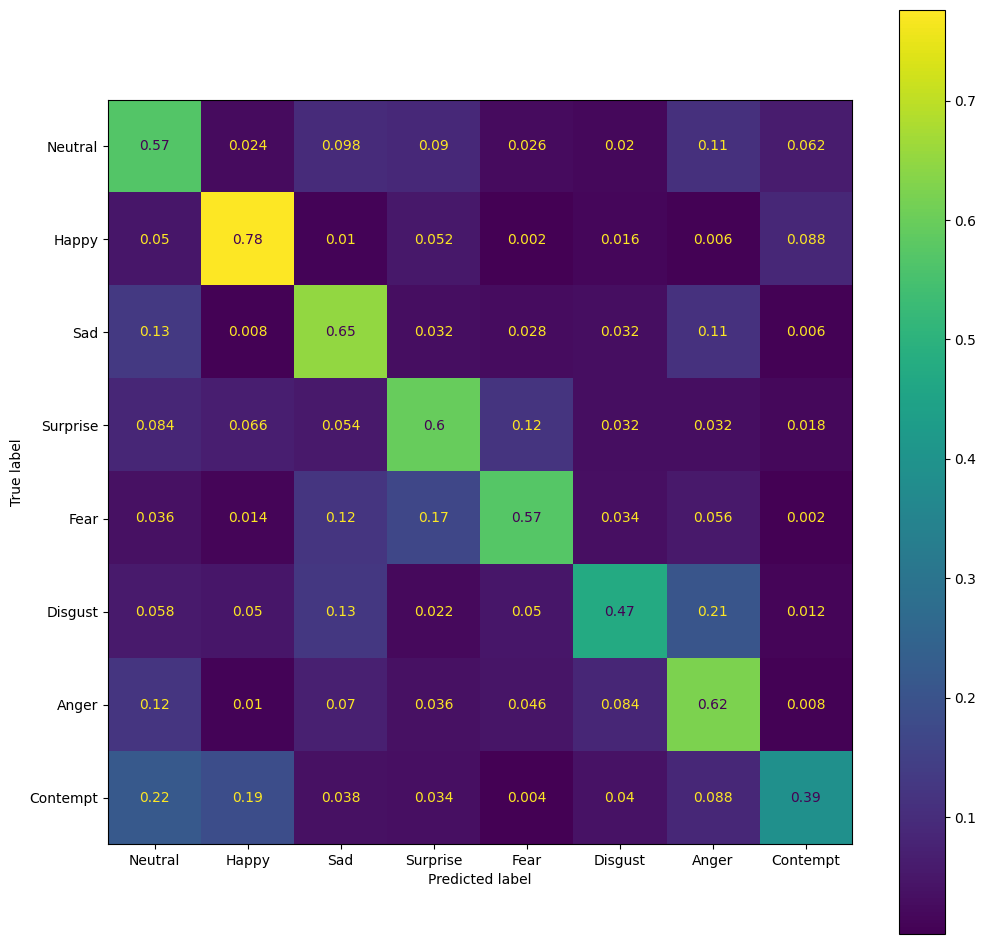

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)